# Neural Network State Space Diagnosis

This notebook performs a deep analysis of neural network activation patterns and state spaces to understand:
1. Why L1 regularization isn't reducing the number of unique states as expected
2. The actual effects of regularization on activation patterns
3. The relationship between activation values, sparsity, and state counting

## Key Questions to Answer:
- Are the activations truly sparse with L1 regularization?
- How does rounding precision affect state counting?
- What's the effective dimensionality of our state space?
- Are there natural clusters in the activation patterns?

In [2]:
# Required imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configure plotting
# plt.style.use('seaborn')
sns.set_style('whitegrid')
%matplotlib inline

# Constants
ROOT = Path('runs') / 'fashion_cv_l1_dropoutLows_l2'
ROUNDING_DECIMALS = [1, 2, 3, 4, 5]  # We'll try different precisions
SPARSITY_THRESHOLDS = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]  # Different thresholds for considering a value "zero"

In [3]:
# Helper functions for analysis
def load_activations(file_path):
    """Load activation data and remove labels if present."""
    df = pd.read_csv(file_path)
    # Remove label columns if they exist
    if 'pred_label' in df.columns:
        df = df.drop(['pred_label', 'true_label'], axis=1)
    return df

def count_unique_states(data, decimals=2, threshold=None):
    """Count unique states with optional threshold for sparsification."""
    # Apply threshold if specified
    if threshold is not None:
        data = np.where(np.abs(data) < threshold, 0, data)
    
    # Round and get unique rows
    rounded = np.round(data, decimals=decimals)
    patterns = [tuple(row) for row in rounded]
    return len(set(patterns))

def calculate_sparsity(data, threshold=1e-5):
    """Calculate sparsity metrics for the activations."""
    total_elements = data.size
    near_zero = np.sum(np.abs(data) < threshold)
    return {
        'sparsity_ratio': near_zero / total_elements,
        'unique_values': len(np.unique(np.round(data, decimals=5))),
        'min_abs_nonzero': np.min(np.abs(data[np.abs(data) >= threshold])) if np.any(np.abs(data) >= threshold) else 0,
        'max_abs': np.max(np.abs(data))
    }

def analyze_dimensionality(data, n_components=None):
    """Analyze effective dimensionality using PCA."""
    if n_components is None:
        n_components = min(data.shape[1], 50)  # Cap at 50 components
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(data_scaled)
    
    return {
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_),
        'n_components_95': np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
    }

## 1. Load and Prepare Data

First, we'll load the activation data from the experiment with the strongest L1 regularization (λ=1.0) to understand why we're still seeing so many unique states despite strong regularization.

In [4]:
# Find the experiment directory with highest L1 regularization
l1_dirs = list(ROOT.glob('l1_weight_1*'))
if not l1_dirs:
    raise ValueError("No L1 experiment directories found!")

# Load activations from first fold
fold_dir = next(l1_dirs[0].glob('fold*'))
activation_file = next(fold_dir.glob('activations_collected_epoch20_fold*.csv'))
print(f"Loading activations from: {activation_file}")

# Load the data
activations_df = load_activations(activation_file)
print("\nActivation data shape:", activations_df.shape)
print("\nBasic statistics:")
print(activations_df.describe())

Loading activations from: runs\fashion_cv_l1_dropoutLows_l2\l1_weight_1.0\fold1\activations_collected_epoch20_fold1.csv

Activation data shape: (30000, 64)

Basic statistics:
              act_0         act_1         act_2         act_3         act_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.256366      1.352479     80.939316     13.584162      1.651642   
std        1.696227      6.274324     61.111939     22.607356      5.522251   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000     11.568694      0.000000      0.000000   
50%        0.000000      0.000000     89.149227      0.000000      0.000000   
75%        0.000000      0.000000    131.629150     21.066901      0.000000   
max       29.795145     69.387611    271.957092    168.894806     45.648460   

              act_5         act_6         act_7         act_8         act_9  \
count  30000.000000  30000.000000 

## 2. Analyze Activation Patterns

Let's examine how different rounding precisions and sparsity thresholds affect our state counts. This will help us understand if the high number of states is due to:
1. Numerical precision issues
2. Ineffective L1 regularization
3. Or genuinely different activation patterns

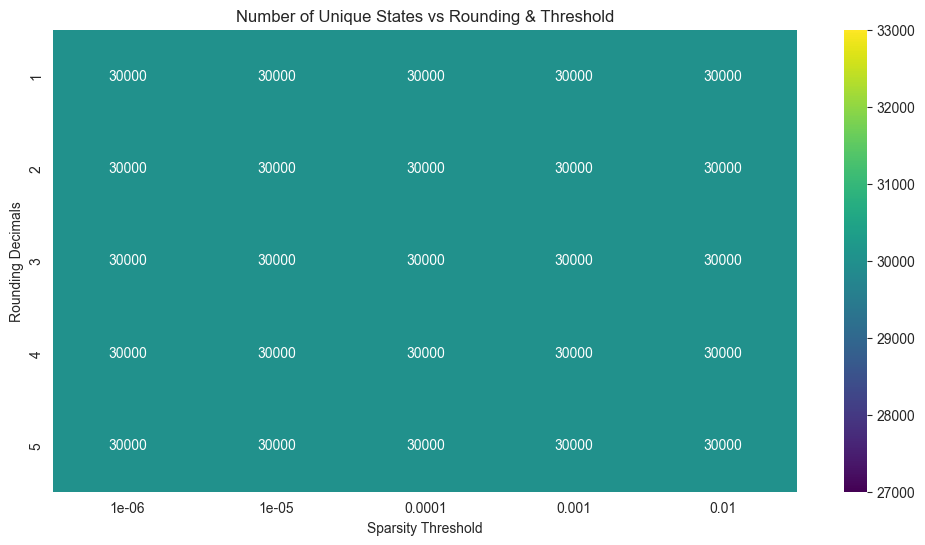

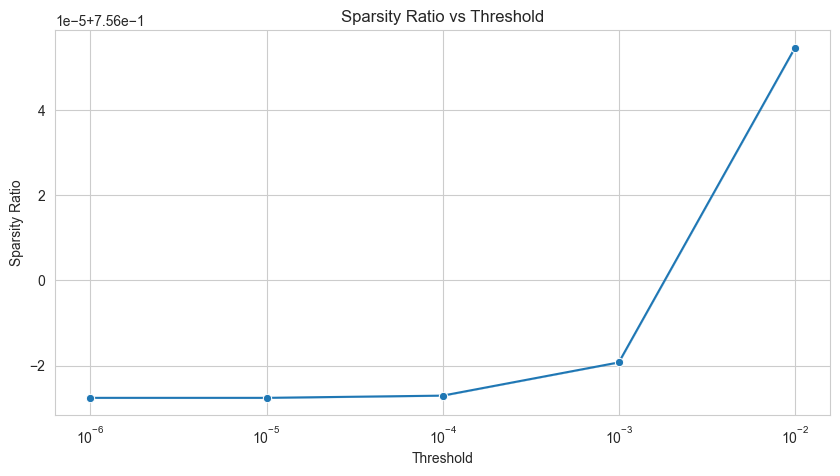

In [5]:
# Analyze how rounding precision affects state counts
data = activations_df.values
results = []

for decimals in ROUNDING_DECIMALS:
    for threshold in SPARSITY_THRESHOLDS:
        n_states = count_unique_states(data, decimals=decimals, threshold=threshold)
        sparsity = calculate_sparsity(data, threshold=threshold)
        
        results.append({
            'decimals': decimals,
            'threshold': threshold,
            'n_states': n_states,
            'sparsity_ratio': sparsity['sparsity_ratio'],
            'unique_values': sparsity['unique_values']
        })

results_df = pd.DataFrame(results)

# Create heatmap of state counts
plt.figure(figsize=(12, 6))
state_matrix = results_df.pivot(index='decimals', columns='threshold', values='n_states')
sns.heatmap(state_matrix, annot=True, fmt='g', cmap='viridis')
plt.title('Number of Unique States vs Rounding & Threshold')
plt.xlabel('Sparsity Threshold')
plt.ylabel('Rounding Decimals')
plt.show()

# Plot sparsity ratio for different thresholds
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='threshold', y='sparsity_ratio', marker='o')
plt.xscale('log')
plt.title('Sparsity Ratio vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Sparsity Ratio')
plt.grid(True)
plt.show()

## 3. State Space Dimensionality

Now let's analyze the effective dimensionality of our state space using PCA. This will help us understand if the high number of states is due to meaningful variations across many dimensions or just noise in a few dimensions.

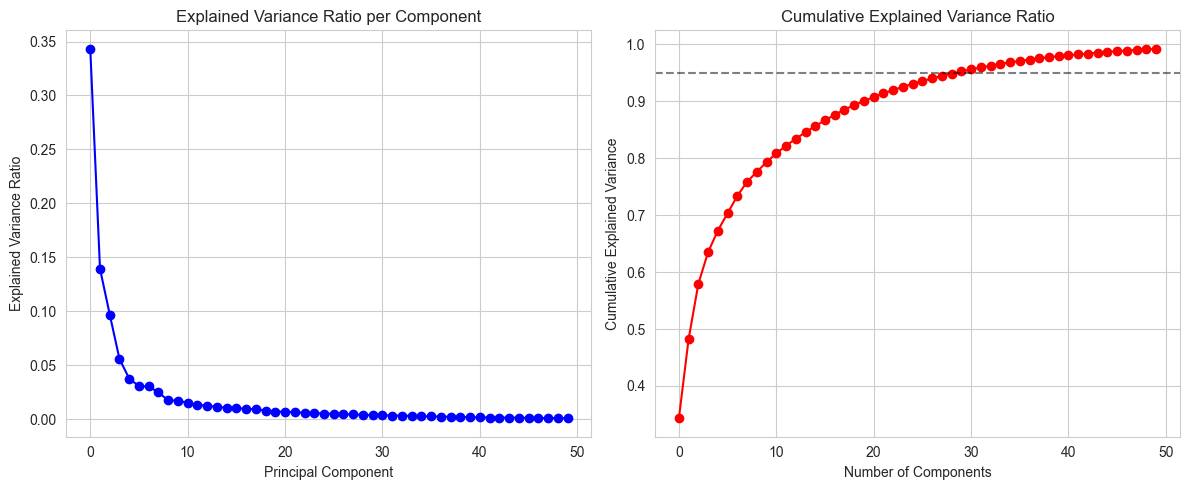


Number of components needed for 95% variance: 30


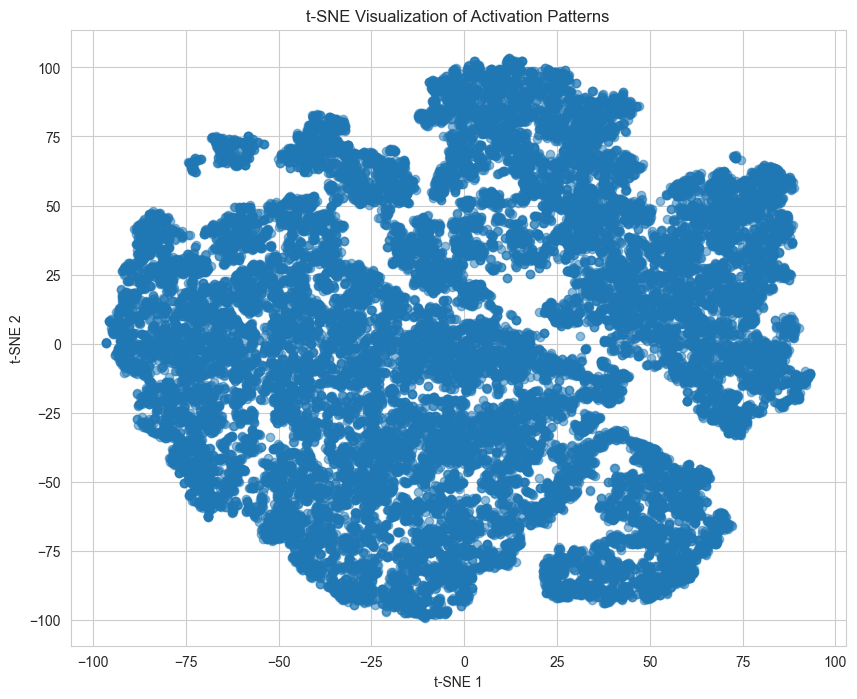

In [6]:
# Analyze dimensionality
dim_analysis = analyze_dimensionality(data)

# Plot explained variance ratio
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(dim_analysis['explained_variance_ratio'], 'bo-')
plt.title('Explained Variance Ratio per Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(dim_analysis['cumulative_variance_ratio'], 'ro-')
plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.5)
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nNumber of components needed for 95% variance: {dim_analysis['n_components_95']}")

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(StandardScaler().fit_transform(data))

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Activation Patterns')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## 4. Activation Sparsity Analysis

Let's examine the sparsity patterns in more detail to understand if L1 regularization is having its intended effect of pushing activations toward zero.

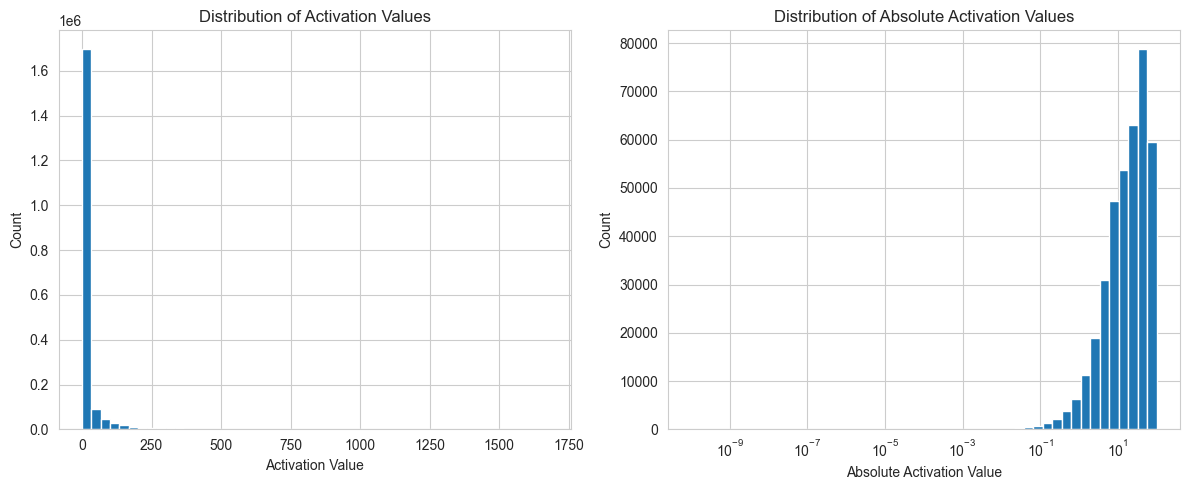


Per-neuron statistics:
       mean_activation  std_activation   sparsity      max_abs
count        64.000000       64.000000  64.000000    64.000000
mean         16.396092       24.530273   0.755972   216.515898
std          36.411416       42.039934   0.277028   318.550813
min           0.005793        0.170347   0.003333     8.727663
25%           0.405112        3.042225   0.674733    40.204324
50%           2.333604        9.756026   0.866917   106.920120
75%          12.517834       27.032504   0.979517   221.764545
max         236.484465      239.986853   0.997667  1673.681519


In [7]:
# Analyze activation distributions
activation_values = data.flatten()

# Plot histogram of activation values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(activation_values, bins=50)
plt.title('Distribution of Activation Values')
plt.xlabel('Activation Value')
plt.ylabel('Count')
plt.grid(True)

# Plot histogram of absolute values (log scale)
plt.subplot(1, 2, 2)
plt.hist(np.abs(activation_values), bins=np.logspace(-10, 2, 50))
plt.xscale('log')
plt.title('Distribution of Absolute Activation Values')
plt.xlabel('Absolute Activation Value')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate per-neuron statistics
neuron_stats = pd.DataFrame({
    'mean_activation': np.mean(data, axis=0),
    'std_activation': np.std(data, axis=0),
    'sparsity': np.mean(np.abs(data) < 1e-5, axis=0),
    'max_abs': np.max(np.abs(data), axis=0)
})

print("\nPer-neuron statistics:")
print(neuron_stats.describe())

## 5. State Clustering Analysis

Let's try to understand if our states form natural clusters, which might indicate that many of our unique states are just slight variations of a smaller set of fundamental patterns.


Trying 5 clusters...
Silhouette score: 0.285
Cluster sizes: [14820  1617   137  4212  9214]

Trying 10 clusters...
Silhouette score: 0.252
Cluster sizes: [6252 3400 1333 5947 2797  146 3773 3478    4 2870]

Trying 20 clusters...
Silhouette score: 0.246
Cluster sizes: [5011 1941  763 3390  813   73 1200 2011    4 2212 2038 2534 1132 3395
 1448  171 1441  132  273   18]

Trying 50 clusters...
Silhouette score: 0.225
Cluster sizes: [1551 1009  889  139 1772   37  322  315 1095   10 1914   43  961 1286
 1400   21  758   49  267  390  205  519  128    1 1544   14   15 1458
    1   91  157   51   11   79  475 2828  990  698 1513  561   12   39
    2   16   47  211  959  636 2463   48]

Trying 100 clusters...
Silhouette score: 0.195
Cluster sizes: [1551  488  124 1299   23  240   95  164    5 1155 1669  289  663    8
    6   37  733    7  129    1  395   86  538  896  494  124  357   18
   12    1  623   15   34  411  847    1   93 1658  272  602   80   25
    6  148  157    6   38    9  341

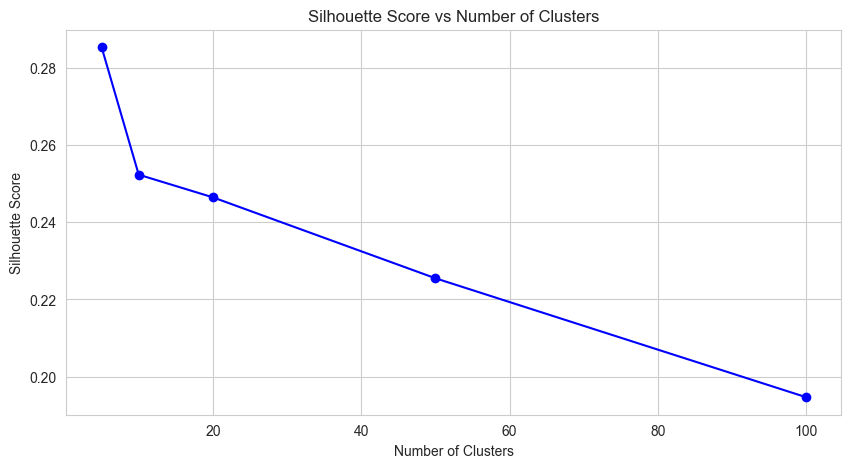

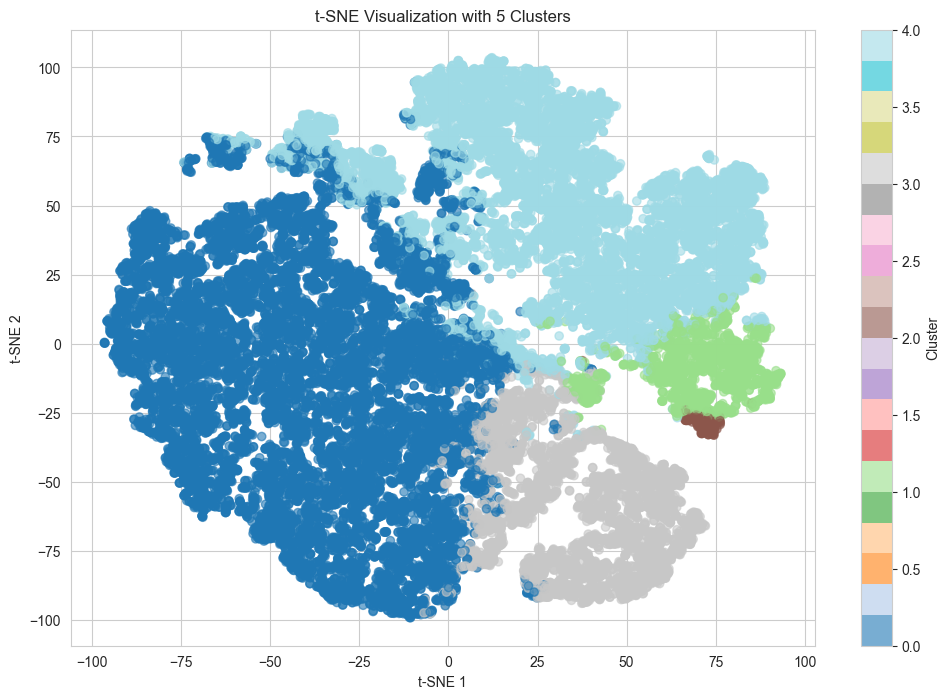

In [8]:
# Apply clustering to the activation patterns
# First reduce dimensionality to speed up clustering
pca = PCA(n_components=0.95)  # Keep 95% of variance
data_reduced = pca.fit_transform(StandardScaler().fit_transform(data))

# Try different numbers of clusters
n_clusters_range = [5, 10, 20, 50, 100]
silhouette_scores = []
cluster_sizes = []

for n_clusters in n_clusters_range:
    print(f"\nTrying {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_reduced)
    
    # Calculate silhouette score
    score = silhouette_score(data_reduced, labels)
    silhouette_scores.append(score)
    
    # Get cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    cluster_sizes.append(counts)
    print(f"Silhouette score: {score:.3f}")
    print("Cluster sizes:", counts)

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, silhouette_scores, 'bo-')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Use best number of clusters for visualization
best_k = n_clusters_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(data_reduced)

# Visualize clusters using t-SNE
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab20', alpha=0.6)
plt.title(f't-SNE Visualization with {best_k} Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')
plt.show()

## 6. Visualization of State Distributions

Finally, let's create detailed visualizations to understand the structure of our activation patterns and how they relate to each other.

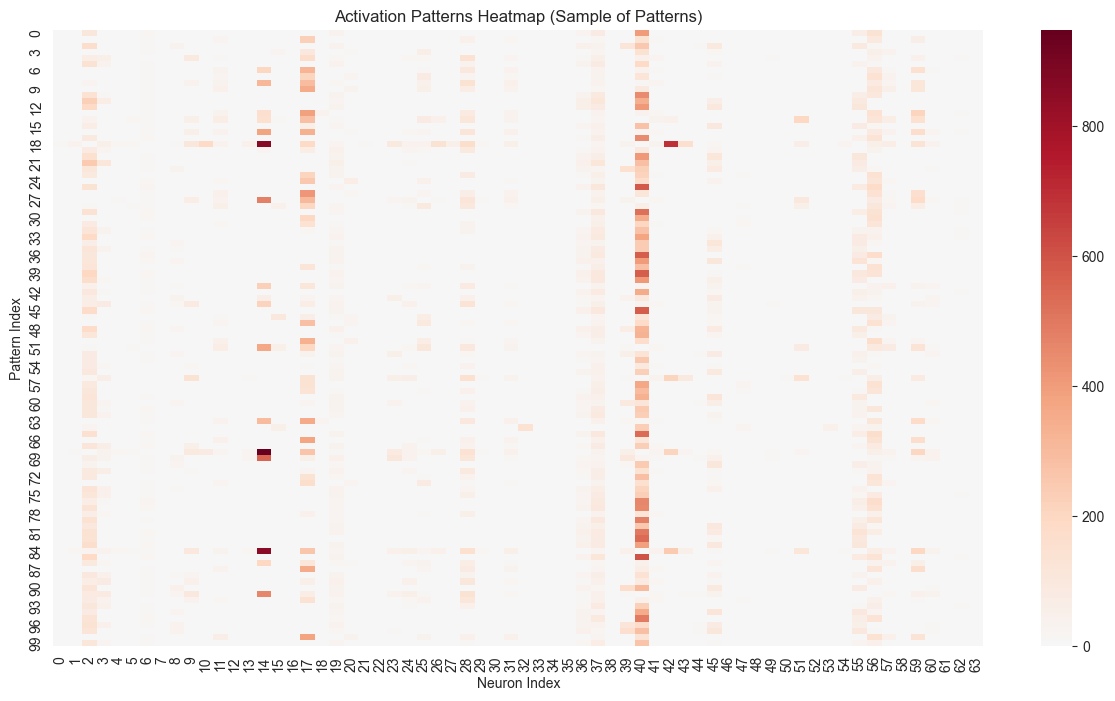

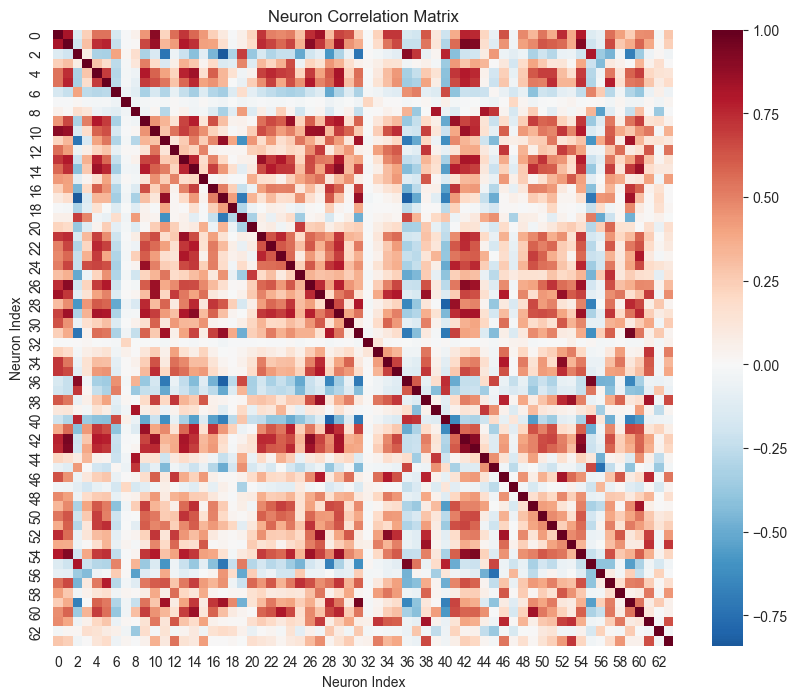

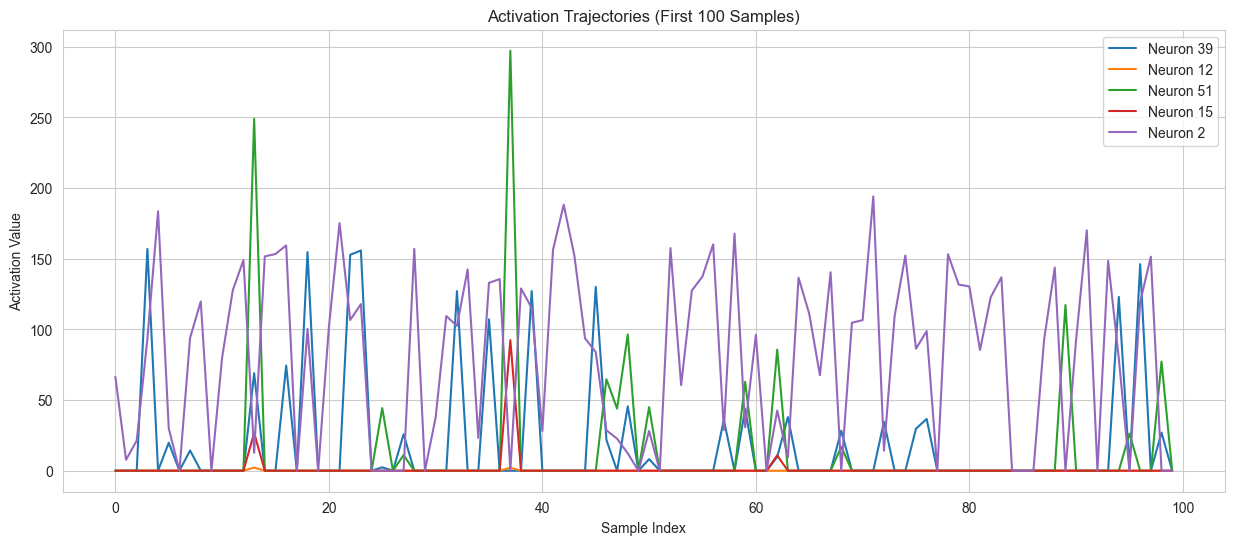


Summary of Visualization Analysis:
- Number of samples analyzed: 30000
- Number of neurons: 64
- Average correlation between neurons: 0.286
- Maximum absolute correlation between different neurons: 0.953


In [9]:
# Create heatmap of activation patterns
# Sample 100 random patterns for visualization
n_samples = min(100, data.shape[0])
sample_idx = np.random.choice(data.shape[0], n_samples, replace=False)
sample_data = data[sample_idx]

plt.figure(figsize=(15, 8))
sns.heatmap(sample_data, cmap='RdBu_r', center=0)
plt.title('Activation Patterns Heatmap (Sample of Patterns)')
plt.xlabel('Neuron Index')
plt.ylabel('Pattern Index')
plt.show()

# Create correlation matrix of neurons
correlation_matrix = np.corrcoef(data.T)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='RdBu_r', center=0)
plt.title('Neuron Correlation Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.show()

# Plot activation trajectories for a few neurons
plt.figure(figsize=(15, 6))
n_neurons_show = 5
neurons_to_show = np.random.choice(data.shape[1], n_neurons_show, replace=False)
for i, neuron_idx in enumerate(neurons_to_show):
    plt.plot(data[:100, neuron_idx], label=f'Neuron {neuron_idx}')
plt.title('Activation Trajectories (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Activation Value')
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics for visualization
print("\nSummary of Visualization Analysis:")
print(f"- Number of samples analyzed: {data.shape[0]}")
print(f"- Number of neurons: {data.shape[1]}")
print(f"- Average correlation between neurons: {np.mean(np.abs(correlation_matrix - np.eye(data.shape[1]))):.3f}")
print(f"- Maximum absolute correlation between different neurons: {np.max(np.abs(correlation_matrix - np.eye(data.shape[1]))):.3f}")